In [1]:
using AutomotiveDrivingModels
using AutoViz
using Reactive
using Interact
using SplineUtils
using SplineRaceWay
using HierarchicalRecedingHorizonController
using NearestNeighbors
using Distributions

/Users/kyle/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# scene parameters
scene = Scene()
framerate = 24
Δt = 1.0/framerate # size of rendering timesteps
n_integration_sub_steps = 3 # sub steps for smoother integration
context = IntegratedContinuous(Δt, n_integration_sub_steps) # integrated continuous context

#car parameters
car_length = 4.8 # front wheel to back wheel
car_width = 2.5
v⁰  = 0.0 # initial velocity
δ⁰ = 0.0 # initical steering angle

############### INITIALIZE TRACK ################
lane_width = 30.0
radius = 45.0
edge_buffer = 0.25
T_MAX = lane_width/2.0 - car_width/2.0 - edge_buffer # max allowable projection distance from center of lane
base_speed= 0.0

# spline control points
Pts = 50*[0 -1 -2 -3 -3.5 -3 -2 -1 -0.5 -1 -2 -3 -4 -5 -6 -6.5 -6 -5.5 -6 -6 -5 -4 -3 -2 -1.5 -1 0 1 1.5 2 3 4 5 6.25 7 7 7 7 7 7 7 6 5 4 4 4 3 2 1 0; 
       0 0 0 0 -1 -2 -2 -2 -3 -4 -4 -4 -4 -4 -4 -3 -2 -1 0 1 2 3 4 4 3 2 2 2 3 4 4 4 4 4 3 2 1 0 -1 -2 -3 -4 -4 -3 -2 -1 0 0 0 0]
degree = 3 # degree of spline
num_points = 10001
num_samples = 1000

track = Raceway(Pts,degree,num_points,num_samples,lane_width)

carcolors = Dict{Int, Colorant}()

roadind1 = RoadIndex(CurveIndex(4,0),LaneTag(1,1))
vehstate1 = VehicleState(Frenet(roadind1, track.roadway), track.roadway, 0.0)
vehdef1 = VehicleDef(1,AgentClass.CAR, car_length, car_width)
push!(scene,Vehicle(vehstate1, vehdef1))
carcolors[1] = colorant"red"
track.models[1] = mapHRHC(1,track.roadway,context,h=12,v_max=120.0,μ=30.0,a_step=12.0,a_range=[-1,0,1],k=2)

roadind2 = RoadIndex(CurveIndex(4,0),LaneTag(1,1))
vehstate2 = VehicleState(Frenet(roadind2, track.roadway), track.roadway, 0.0)
vehdef2 = VehicleDef(2,AgentClass.CAR, car_length, car_width)
push!(scene,Vehicle(vehstate2, vehdef2))
carcolors[2] = colorant"blue"
track.models[2] = mapHRHC(2,track.roadway,context,h=12,v_max=125.0,μ=32.0,a_step=12.0,a_range=[-1,0,1],k=3)

roadind3 = RoadIndex(CurveIndex(14,0),LaneTag(1,1))
vehstate3 = VehicleState(Frenet(roadind3, track.roadway), track.roadway, 0.0)
vehdef3 = VehicleDef(3,AgentClass.CAR, car_length, car_width)
push!(scene,Vehicle(vehstate3, vehdef3))
carcolors[3] = colorant"yellow"
track.models[3] = mapHRHC(3,track.roadway,context,h=12,v_max=100.0,μ=25.0,a_step=12.0,a_range=[-1,0,1],k=3)

roadind4 = RoadIndex(CurveIndex(410,0),LaneTag(1,1))
vehstate4 = VehicleState(Frenet(roadind4, track.roadway), track.roadway, 0.0)
vehdef4 = VehicleDef(4,AgentClass.CAR, car_length, car_width)
push!(scene,Vehicle(vehstate4, vehdef4))
carcolors[4] = colorant"green"
track.models[4] = mapHRHC(4,track.roadway,context,h=12,v_max=125.0,μ=36.0,a_step=16.0,a_range=[-1,0,1],k=1)

actions = Array(DriveAction, length(scene))

track.obstacleMap = generateObstacleMap(scene, track.models)
track;

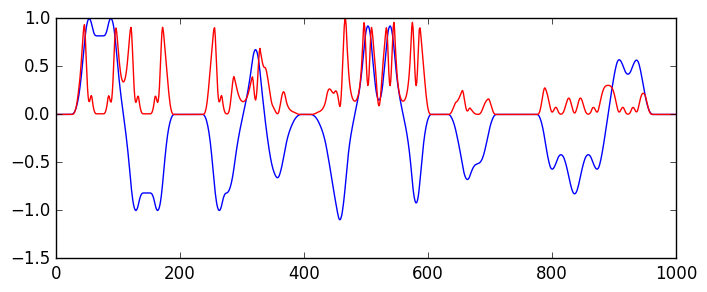

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x3246b5690>

In [3]:
# moving average filter over curvature - used to guide motion primitive search for controller
agent = track.models[1]
filtersize = agent.h

μk = [mean(track.k[i:i+filtersize]) for i in 1:(length(track.k) - filtersize)]
σk = [var(track.k[i:i+filtersize]) for i in 1:(length(track.k) - filtersize)]
σk = σk / maximum(σk) # normalized variance
for _ in 1:filtersize # lazy wrapping - FIX LATER
    push!(μk,0.0)
    push!(σk,0)
end

PyPlot.figure(figsize=[8,3])
PyPlot.plot(μk/maximum(μk))
PyPlot.plot(σk,c="r")

In [4]:
function samplePath(s,t,ϕ,μk,σk,agent) # σk should be normalize
    h_pdf = Truncated(Normal(agent.h*(1-.5*σk),.5*agent.h/(2+σk)),1,agent.h)
    
    ζ = atan(μk*agent.wheel_base)
    idx = Int(round(.5+length(agent.δ_range)/2 * (1 - .5*sign(ϕ)*sqrt(abs(ϕ)) + sign(ζ)*sqrt(abs(ζ))/(sqrt(maximum(agent.δ_range))))))
    idx = min(length(agent.δ_range),max(1,idx))
    δ_pdf = Truncated(Normal(idx,10.0/(3-σk)),1,43)
    
    v_pdf = DiscreteUniform(1,3)
    
    v_cmd = rand(v_pdf)
    δ_cmd = Int(round(rand(δ_pdf)))
    h_cmd = Int(round(rand(h_pdf)))
    
    return v_cmd, δ_cmd, h_cmd
end

samplePath (generic function with 1 method)

In [5]:
type pathSegment
    x::Array{Float64}
    y::Array{Float64}
    θ::Array{Float64}
    s::Float64
    t::Float64
    ϕ::Float64
    v_idx::Int
    h::Int
    c_idx::Int # curve index
    obj::Float64
    
    function pathSegment(v_cmd,δ_cmd,h,x₀,y₀,θ₀,s₀,vᵢ,track,agent)
        pS = new()
        pS.h = h
        ΔXYθ = agent.motion_map[vᵢ][v_cmd,δ_cmd,1:h,:]
        pS.x = x₀ + cos(θ₀)*ΔXYθ[:,1] - sin(θ₀)*ΔXYθ[:,2]
        pS.y = y₀ + sin(θ₀)*ΔXYθ[:,1] + cos(θ₀)*ΔXYθ[:,2]
        pS.θ = θ₀ + ΔXYθ[:,3]
        v_idx = vᵢ
        for _ in 1:h
            # may want to pre-compute this in motion primitives
            v_idx = agent.v_map[v_idx][v_cmd,δ_cmd] # increment velocity to the appropriate level
        end
        pS.v_idx = v_idx
        c_idx,dist = knn(track.tree,[pS.x[end];pS.y[end]],1)
        pS.c_idx = c_idx[1]
        pS.s, pS.t, pS.ϕ = kdProject(pS.x[end],pS.y[end],pS.θ[end],track.tree,track.roadway,agent)
        pS.obj = calculateObjective(agent.car_ID,s₀,pS.s,pS.t,pS.ϕ,agent.T_MAX;ϕ_MAX=Float64(π),s_factor=agent.v)
        
        pS
    end
    
end

In [8]:
agent = track.models[1]
agent.v_cmd = 200
agent.v = agent.v_range[agent.v_cmd]
v_idx = agent.v_cmd

H = 50 # total planning horizon
N = 40 # total trajectories to sample
n = 24 # sampling factor per round
B_paths = [] # base paths
M_paths = [] # incomplete (mid) paths
C_paths = [] # completed paths

o_Array = []

#initial vehicle location
posG = scene.vehicles[agent.car_ID].state.posG
posF = scene.vehicles[agent.car_ID].state.posF

v_idx_range = [i for i in 1:size(agent.motion_map[v_idx],1)]
δ_idx_range = [i for i in 15:29]
h_idx_range = [i for i in 6:agent.h]

# initial trajectories
# v_idxs = rand(v_idx_range,n,1)
# δ_idxs = rand(δ_idx_range,n,1)
# h_idxs = rand(h_idx_range,n,1)

s₀,t₀,ϕ₀ = kdProject(posG.x,posG.y,posG.θ,track.tree,track.roadway,agent)
c,d = knn(track.tree,[posG.x;posG.y],1)

# Branches from root node
for i in 1:n
    v, δ, h = samplePath(s₀,t₀,ϕ₀,μk[c[1]],σk[c[1]],agent)
    push!(M_paths, [pathSegment(v,δ,h,posG.x,posG.y,posG.θ,s₀,agent.v_cmd,track,agent)])
end

# second loop
while length(C_paths) < N
    B_paths = M_paths
    M_paths = []
    
    o_Array = [exp(1/p[end].obj)*(abs(p[end].t) < agent.T_MAX) for p in B_paths]
    o_Array = o_Array/sum(o_Array)
    o_pdf = Categorical(o_Array)
    while length(M_paths) < n && length(C_paths) < N
        path_idx = rand(o_pdf)
        path = copy(B_paths[path_idx])
        base_node = path[end]
        v_idx = base_node.v_idx
        
        v, δ, h = samplePath(base_node.s,base_node.t,base_node.ϕ,μk[base_node.c_idx],σk[base_node.c_idx],agent)
        
        overshoot = sum([p.h for p in path]) + h - H # overshoot past H (full horizon)
        if overshoot >= 0
            h -= overshoot
        end
        
        x₀ = path[end].x[end]
        y₀ = path[end].y[end]
        θ₀ = path[end].θ[end]
                
        seg = pathSegment(v,δ,h,x₀,y₀,θ₀,s₀,base_node.v_idx,track,agent)
        
        if h != 0 && abs(seg.t) < agent.T_MAX
            push!(path, pathSegment(v,δ,h,x₀,y₀,θ₀,s₀,base_node.v_idx,track,agent))
        else
            continue
        end

        if overshoot >= 0
            push!(C_paths,path)
            if length(C_paths) >= N
                break
            end
        else
            push!(M_paths,path)
        end
    end
end
print("done")

done

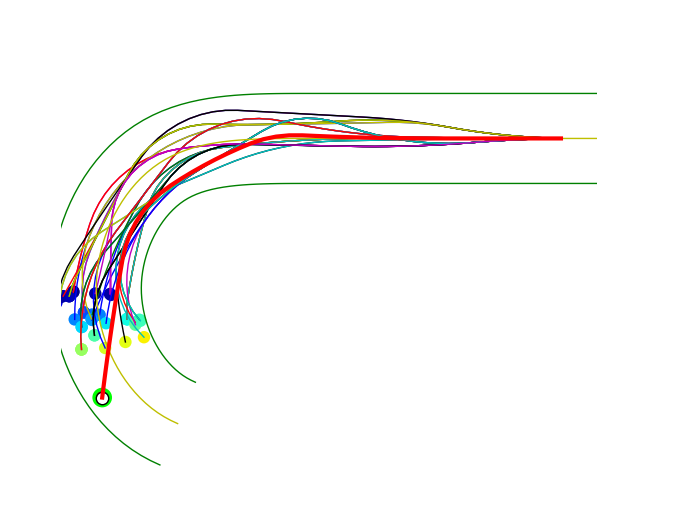

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x327a42650>

In [9]:
objArray = [p[end].obj for p in C_paths]
xArray = [p[end].x[end] for p in C_paths]
yArray = [p[end].y[end] for p in C_paths]
sArray = [p[end].s for p in C_paths]

for i in 1:N
    arr = nothing
    path = C_paths[i]
    for p in path
        if arr == nothing
            arr = hcat(p.x,p.y,p.θ)
        else
            arr = vcat(arr,hcat(p.x,p.y,p.θ))
        end
    end
    PyPlot.plot(arr[:,1],arr[:,2])
#     PyPlot.scatter(arr[end,1],arr[end,2],c=1.0/path[end].obj,edgecolor="none",s=80)
end

arr = nothing
path = C_paths[indmax([p[end].s for p in C_paths])]
for p in path
    if arr == nothing
        arr = hcat(p.x,p.y,p.θ)
    else
        arr = vcat(arr,hcat(p.x,p.y,p.θ))
    end
end
PyPlot.scatter(arr[end,1],arr[end,2],c="lime",edgecolor="none",s=200)

PyPlot.scatter(xArray,yArray,c=sArray,edgecolor="none",s=80)
o_idx = indmax(sArray)
PyPlot.scatter(xArray[o_idx],yArray[o_idx],c="white",s=80)
plotSplineRoadway(track.x[1:100],track.y[1:100],track.θ[1:100],lane_width)
PyPlot.axis("off")
arr = nothing
for p in C_paths[o_idx]
    if arr == nothing
        arr = hcat(p.x,p.y,p.θ)
    else
        arr = vcat(arr,hcat(p.x,p.y,p.θ))
    end
end
PyPlot.plot(arr[:,1],arr[:,2],c="red",linewidth=3)

In [ ]:
indmax([p[end].s for p in C_paths])
best_path = C_paths[indmax([p[end].s for p in C_paths])]

# take one step and sample from next path
seed_path = best_path
seed_path;

In [ ]:
seed_path[1].

In [ ]:
# 1/h ∝ σk # likelihood of choosing small h increases with variance of curvature for track ahead
σk = 0.0
μk = 0.0*maximum(track.k) # if curvature positive, want to steer positive (low δ_idx)
t = 0 # if t positive, want to steer negative (high δ_idx)
ϕ = 0

h_prob = Truncated(Normal(12*(1-.5*σk),6.0/(2+σk)),1,12)

v_pdf = Truncated(Uniform(),1,3)

ζ = atan(μk*agent.wheel_base)
idx = Int(round(.5+length(agent.δ_range)/2 * (1 - .5*sign(ϕ)*sqrt(abs(ϕ)) + sign(ζ)*sqrt(abs(ζ))/(sqrt(maximum(agent.δ_range))))))
idx = min(length(agent.δ_range),max(1,idx))


h_range = linspace(0,13,200)
PyPlot.figure(figsize=[12,3])
PyPlot.subplot(1,3,1)
PyPlot.plot(h_range,pdf(h_prob,h_range))
PyPlot.title("pdf for h")
h_idx = max(0,min(12,Int(round(rand(h_prob)))))

v_range = linspace(0,4,10)
PyPlot.subplot(1,3,2)
PyPlot.plot(v_range,pdf(v_pdf,v_range))
PyPlot.title("pdf for v")

δ_prob = Truncated(Normal(idx,30.0/(3-σk)),1,43)
δ_range = linspace(0,44,200)
PyPlot.subplot(1,3,3)
PyPlot.plot(δ_range,pdf(δ_prob,δ_range))
PyPlot.title("pdf for delta")

h = Int(round(rand(h_prob)))
δ = Int(round(rand(δ_prob)))
δ,h


In [ ]:
curvature = maximum(track.k)
curvature = .01

In [ ]:
ζ = atan(curvature*agent.wheel_base)
idx = Int(round(.5+length(agent.δ_range)/2 * (1 + sign(ζ)*sqrt(abs(ζ))/(sqrt(maximum(agent.δ_range))))))
idx = min(length(agent.δ_range),max(1,idx))

In [ ]:
tan(agent.δ_range[idx])/agent.wheel_base

In [ ]:
curvature = tan(agent.δ_range)/agent.wheel_base